In [1]:
#Importing and uploading data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

bids = pd.DataFrame.from_csv('C:/Users/Christopher Gardner/Documents/Python Scripts/bids.csv')
train = pd.DataFrame.from_csv('C:/Users/Christopher Gardner/Documents/Python Scripts/train.csv')

#adding final time features created by subtracting bid time from the last time in the auction. 
test_df = pd.DataFrame.from_csv('C:/Users/Christopher Gardner/Documents/Python Scripts/final_times.csv')
test_df.columns = ['f_time']
bids = bids.merge(test_df, left_on='auction', right_index=True)
test_df = pd.DataFrame.from_csv('C:/Users/Christopher Gardner/Documents/Python Scripts/short_times.csv')
test_df.columns = ['short_time']
bids = bids.merge(test_df, left_on='bidder_id', right_index=True)
bids['diff_time'] = bids.f_time - bids.time
#create proper merge
groupfirst = bids.groupby(bids.bidder_id).nunique().sort_index()
mergedsecond = groupfirst.merge(train.sort_index(), left_index=True, right_index=True)

#now sort by desired values, update ranking and then split into bots and humans for plotting
mergedsecond = mergedsecond.sort_values(by=['auction'])
mergedsecond['ranking'] = np.arange(len(mergedsecond))
mergedsecond['bids_per_auction'] = mergedsecond.time/mergedsecond.auction
bots = mergedsecond[mergedsecond.outcome==1]
humans = mergedsecond[mergedsecond.outcome==0]


#mergefirst
mergedfirst = bids.merge(train, left_on='bidder_id', right_index=True)
groupedsecond = mergedfirst.groupby('bidder_id').nunique()

In [92]:
#Creating Train Test splits and pipeline
from sklearn.model_selection import train_test_split

#X and y 
X = mergedsecond.drop(['outcome', 'payment_account', 'address', 'short_time', 'diff_time'], axis=1)
y = mergedsecond.outcome

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [45]:
X.head()

,bidder_id,auction,merchandise,device,time,country,ip,url,f_time,short_time,diff_time,ranking,bids_per_auction
bidder_id,,,,,,,,,,,,,
001068c415025a009fee375a12cff4fcnht8y,1,1,1,1,1,1,1,1,1,1,1,0,1.0
6394edfbd35aab54801518835e33ed50hcr5f,1,1,1,1,1,1,1,1,1,1,1,1,1.0
640f41f27c03aca0c45775eb918b666cnjsqv,1,1,1,1,1,1,1,1,1,1,1,2,1.0
64f6b099082e4fb2e8da7ba4ae9abdead2cej,1,1,1,2,2,1,2,1,1,1,2,3,2.0
6531bde8d4decd9708ff4407ef95e887a26yi,1,1,1,1,1,1,1,1,1,1,1,4,1.0


In [81]:
y.head()

bidder_id
001068c415025a009fee375a12cff4fcnht8y    0.0
6394edfbd35aab54801518835e33ed50hcr5f    0.0
640f41f27c03aca0c45775eb918b666cnjsqv    0.0
64f6b099082e4fb2e8da7ba4ae9abdead2cej    0.0
6531bde8d4decd9708ff4407ef95e887a26yi    0.0
Name: outcome, dtype: float64

In [93]:
#Creating Pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, f1_score, roc_auc_score, auc

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict_proba(X_test)

In [87]:
y_pred

array([[ 0.93749839,  0.06250161],
       [ 0.93936983,  0.06063017],
       [ 0.94682388,  0.05317612],
       ..., 
       [ 0.94974471,  0.05025529],
       [ 0.39360956,  0.60639044],
       [ 0.9302469 ,  0.0697531 ]])

In [94]:
l = [x[1] for x in y_pred]

In [97]:
f1_score(y_test, logreg.predict(X_test))

0.0

In [89]:
fpr, tpr, _ = roc_curve(y_test, l)

In [98]:
roc_auc_score(y_test, l)

0.80992203219315895

In [95]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred[:, i])

In [83]:
import scikitplot as skplt

y_true = y_test # ground truth labels
y_probas = l# predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

IndexError: too many indices for array

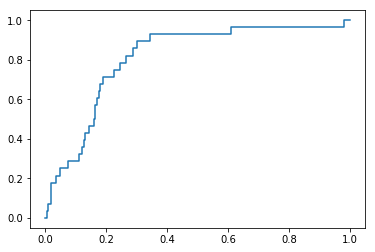

In [96]:
plt.plot(fpr[1],tpr[1])
plt.show()

In [62]:
fpr 

array([ 0.        ,  0.00176056,  0.00528169,  0.00528169,  0.01056338,
        0.01056338,  0.02816901,  0.02816901,  0.21478873,  0.21478873,
        0.32042254,  0.32042254,  0.40140845,  0.40140845,  0.43485915,
        0.43485915,  0.55985915,  0.55985915,  0.6056338 ,  0.6056338 ,
        0.63028169,  0.63028169,  0.63908451,  0.63908451,  0.64788732,
        0.64788732,  0.70422535,  0.70422535,  0.74647887,  0.74647887,
        0.75      ,  0.75      ,  0.76056338,  0.76056338,  0.77816901,
        0.77816901,  0.78521127,  0.78521127,  0.79401408,  0.79401408,
        0.79577465,  0.79577465,  0.85211268,  0.85211268,  0.86619718,
        0.86619718,  0.97359155,  0.97359155,  0.97535211,  0.97535211,
        0.98591549,  0.98591549,  1.        ])

In [63]:
tpr

array([ 0.        ,  0.        ,  0.        ,  0.03571429,  0.03571429,
        0.07142857,  0.07142857,  0.10714286,  0.10714286,  0.14285714,
        0.14285714,  0.17857143,  0.17857143,  0.21428571,  0.21428571,
        0.25      ,  0.25      ,  0.28571429,  0.28571429,  0.32142857,
        0.32142857,  0.35714286,  0.35714286,  0.39285714,  0.39285714,
        0.5       ,  0.5       ,  0.53571429,  0.53571429,  0.57142857,
        0.57142857,  0.60714286,  0.60714286,  0.64285714,  0.64285714,
        0.67857143,  0.67857143,  0.71428571,  0.71428571,  0.75      ,
        0.75      ,  0.78571429,  0.78571429,  0.85714286,  0.85714286,
        0.89285714,  0.89285714,  0.92857143,  0.92857143,  0.96428571,
        0.96428571,  1.        ,  1.        ])

In [43]:
logreg.score(X_train,y_train)

0.94596541786743515

In [44]:
logreg.score(X_test, y_test)

0.95134228187919467

In [ ]:
#looks like this model is simply predicting no bots. 